In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!apt-get update
!apt-get install -y ffmpeg libespeak-dev libportaudio2 build-essential python3-dev


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,002 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [80.4 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,791 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-

In [ ]:
# Install system dependencies
!apt-get update
!apt-get install -y ffmpeg libespeak-dev libportaudio2 build-essential python3-dev

# Install cython
!pip install cython

# Download aeneas source and install manually
!git clone https://github.com/readbeyond/aeneas.git
%cd aeneas
!python3 setup.py build
!python3 setup.py install


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [ ]:
# Install dependencies
!pip install git+https://github.com/openai/whisper.git
!pip install transformers datasets jiwer accelerate odfpy
!sudo apt update && sudo apt install -y ffmpeg

import os
import pandas as pd
from odf.opendocument import load
from odf.text import P
import librosa
import torchaudio
import numpy as np
from datasets import Dataset
from transformers import WhisperProcessor, WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
from jiwer import wer
import logging
import math
import re

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Paths to your audio and transcript folders
audio_path = "/content/drive/MyDrive/Anju Project (1)/Audio Prudent media (1)/August 2017 (1)"
transcript_path = "/content/drive/MyDrive/Anju Project (1)/Audio Prudent media (1)/August 2017 (1)"

# Custom function to match audio and transcript files
def create_file_mapping(audio_path, transcript_path):
    """
    Create a mapping between audio files and transcript files based on date patterns
    """
    audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
    transcript_files = [f for f in os.listdir(transcript_path) if f.endswith('.odt')]

    print(f"DEBUG: Found {len(audio_files)} audio files")
    print(f"DEBUG: Found {len(transcript_files)} transcript files")

    # Function to extract date from audio filename
    def extract_date_from_audio(filename):
        # Pattern for "Konkani Prime News_070817.wav" -> extract "070817"
        match = re.search(r'_(\d{6})\.wav', filename)
        if match:
            date_str = match.group(1)  # "070817"
            # Convert to day format: "070817" -> "7" (remove leading zero from day)
            day = int(date_str[:2])  # "07" -> 7
            return str(day)
        return None

    # Function to extract date from transcript filename
    def extract_date_from_transcript(filename):
        # Pattern for "7 AUG PRIME.odt" -> extract "7"
        match = re.search(r'^(\d+)\s+AUG', filename)
        if match:
            return match.group(1)  # "7"
        return None

    # Create mapping
    file_pairs = []
    for audio_file in audio_files:
        audio_date = extract_date_from_audio(audio_file)
        if not audio_date:
            print(f"WARNING: Could not extract date from audio file: {audio_file}")
            continue

        # Find matching transcript
        matching_transcript = None
        for transcript_file in transcript_files:
            transcript_date = extract_date_from_transcript(transcript_file)
            if transcript_date and transcript_date == audio_date:
                matching_transcript = transcript_file
                break

        if matching_transcript:
            file_pairs.append((audio_file, matching_transcript))
            print(f"MATCHED: {audio_file} <-> {matching_transcript}")
        else:
            print(f"NO MATCH: {audio_file} (date: {audio_date})")

    print(f"\nSUCCESSFULLY MATCHED: {len(file_pairs)} pairs")
    return file_pairs

# DEBUG: Check if paths exist
print(f"DEBUG: Audio path exists: {os.path.exists(audio_path)}")
print(f"DEBUG: Transcript path exists: {os.path.exists(transcript_path)}")

if os.path.exists(audio_path):
    audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
    print(f"DEBUG: Found {len(audio_files)} .wav files in audio directory")
    print(f"DEBUG: First few audio files: {audio_files[:5]}")
else:
    print("DEBUG: Audio path does not exist!")
    # List what's actually in the parent directory
    parent_dir = os.path.dirname(audio_path)
    if os.path.exists(parent_dir):
        print(f"DEBUG: Contents of parent directory {parent_dir}:")
        print(os.listdir(parent_dir))

if os.path.exists(transcript_path):
    transcript_files = [f for f in os.listdir(transcript_path) if f.endswith('.odt')]
    print(f"DEBUG: Found {len(transcript_files)} .odt files in transcript directory")
    print(f"DEBUG: First few transcript files: {transcript_files[:5]}")
else:
    print("DEBUG: Transcript path does not exist!")
    # List what's actually in the parent directory
    parent_dir = os.path.dirname(transcript_path)
    if os.path.exists(parent_dir):
        print(f"DEBUG: Contents of parent directory {parent_dir}:")
        print(os.listdir(parent_dir))

# Function to read ODT transcript with error handling
def read_odt(file_path):
    try:
        print(f"DEBUG: Attempting to read ODT file: {file_path}")
        doc = load(file_path)
        paragraphs = []
        for p in doc.getElementsByType(P):
            text_parts = []
            for node in p.childNodes:
                if hasattr(node, "data"):
                    text_parts.append(node.data)
                elif hasattr(node, "childNodes"):
                    for subnode in node.childNodes:
                        if hasattr(subnode, "data"):
                            text_parts.append(subnode.data)
            if text_parts:
                paragraphs.append("".join(text_parts))
        text = " ".join(paragraphs).strip()
        print(f"DEBUG: Successfully read ODT, text length: {len(text)} characters")
        if len(text) > 0:
            print(f"DEBUG: First 100 characters: {text[:100]}")
        return text
    except Exception as e:
        logger.error(f"Error reading {file_path}: {e}")
        print(f"DEBUG: Full error details: {str(e)}")
        return None

# Function to load and preprocess audio using librosa
def load_and_preprocess_audio(audio_file, target_sr=16000):
    try:
        print(f"DEBUG: Attempting to load audio file: {audio_file}")
        logger.info(f"Loading audio file: {audio_file}")
        audio_array, sample_rate = librosa.load(audio_file, sr=target_sr, mono=True)
        audio_array = audio_array.astype(np.float32)

        # Normalize if needed
        if np.max(np.abs(audio_array)) > 1.0:
            audio_array = audio_array / np.max(np.abs(audio_array))

        print(f"DEBUG: Successfully loaded audio, shape: {audio_array.shape}, duration: {len(audio_array)/sample_rate:.2f}s")
        logger.info(f"Loaded and preprocessed {audio_file}: shape={audio_array.shape}, sr={sample_rate}")
        return audio_array, sample_rate

    except Exception as e:
        logger.error(f"Error loading audio {audio_file}: {e}")
        print(f"DEBUG: Audio loading error details: {str(e)}")
        return None, None

# Function to chunk text into smaller pieces
def chunk_text_by_tokens(text, processor, max_tokens=400):
    """
    Chunk text to stay under token limit, trying to break at sentence boundaries
    """
    # First check if text is already short enough
    tokens = processor.tokenizer(text).input_ids
    if len(tokens) <= max_tokens:
        return [text]

    # Split by sentences first
    sentences = text.replace('।', '।\n').replace('.', '.\n').replace('!', '!\n').replace('?', '?\n').split('\n')
    sentences = [s.strip() for s in sentences if s.strip()]

    chunks = []
    current_chunk = []
    current_tokens = 0

    for sentence in sentences:
        sentence_tokens = len(processor.tokenizer(sentence).input_ids)

        # If adding this sentence would exceed limit, save current chunk and start new one
        if current_tokens + sentence_tokens > max_tokens and current_chunk:
            chunk_text = ' '.join(current_chunk)
            chunks.append(chunk_text)
            current_chunk = [sentence]
            current_tokens = sentence_tokens
        else:
            current_chunk.append(sentence)
            current_tokens += sentence_tokens

    # Add the last chunk
    if current_chunk:
        chunk_text = ' '.join(current_chunk)
        chunks.append(chunk_text)

    return chunks

# Function to chunk audio to match text chunks
def chunk_audio_proportionally(audio_array, text_chunks, total_text_length):
    """
    Split audio proportionally based on text chunk lengths
    """
    audio_chunks = []
    audio_length = len(audio_array)
    current_pos = 0

    for i, chunk_text in enumerate(text_chunks):
        chunk_length = len(chunk_text)
        chunk_ratio = chunk_length / total_text_length

        if i == len(text_chunks) - 1:  # Last chunk gets remaining audio
            chunk_audio = audio_array[current_pos:]
        else:
            chunk_samples = int(audio_length * chunk_ratio)
            chunk_audio = audio_array[current_pos:current_pos + chunk_samples]
            current_pos += chunk_samples

        audio_chunks.append(chunk_audio)

    return audio_chunks

# Only proceed if both directories exist
if not os.path.exists(audio_path) or not os.path.exists(transcript_path):
    print("\n=== DIRECTORY PATH ISSUE ===")
    print("One or both directories don't exist. Please check your paths:")
    print(f"Audio path: {audio_path}")
    print(f"Transcript path: {transcript_path}")
    print("\nTry checking your Google Drive mount or directory structure.")
    exit()

# Create file mapping using custom matching logic
print("\n=== CREATING FILE MAPPINGS ===")
file_pairs = create_file_mapping(audio_path, transcript_path)

if not file_pairs:
    print("\n=== NO FILE MATCHES FOUND ===")
    print("Please check if your files follow the expected naming patterns:")
    print("Audio: 'Konkani Prime News_DDMMYY.wav' (e.g., 'Konkani Prime News_070817.wav')")
    print("Transcript: 'DD AUG PRIME.odt' (e.g., '7 AUG PRIME.odt')")
    exit()

# Load Whisper processor first for tokenization
print("DEBUG: Loading Whisper processor...")
model_name = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_name)
print("DEBUG: Whisper processor loaded successfully")

# Collect and chunk data with detailed debugging
print("\n=== PROCESSING MATCHED FILES ===")
data = []
processed_count = 0
skipped_count = 0

for audio_file, transcript_file in file_pairs:
    print(f"\n--- Processing pair: {audio_file} <-> {transcript_file} ---")

    full_audio_path = os.path.join(audio_path, audio_file)
    full_transcript_path = os.path.join(transcript_path, transcript_file)

    # Read transcript
    text = read_odt(full_transcript_path)
    if not text or len(text.strip()) == 0:
        print(f"DEBUG: Empty or invalid transcript for {transcript_file}")
        logger.warning(f"Empty transcript for {transcript_file}")
        skipped_count += 1
        continue

    # Load audio
    audio_array, sr = load_and_preprocess_audio(full_audio_path)
    if audio_array is None:
        print(f"DEBUG: Failed to load audio: {audio_file}")
        logger.warning(f"Failed to load audio: {audio_file}")
        skipped_count += 1
        continue

    # Check if text needs chunking
    tokens = processor.tokenizer(text).input_ids
    print(f"DEBUG: File {audio_file}: text length = {len(text)} chars, tokens = {len(tokens)}")
    logger.info(f"File {audio_file}: text length = {len(text)} chars, tokens = {len(tokens)}")

    if len(tokens) > 400:  # Need to chunk
        print(f"DEBUG: Chunking {audio_file} (tokens: {len(tokens)})")
        logger.info(f"Chunking {audio_file} (tokens: {len(tokens)})")
        text_chunks = chunk_text_by_tokens(text, processor, max_tokens=400)
        audio_chunks = chunk_audio_proportionally(audio_array, text_chunks, len(text))

        # Add each chunk as a separate training sample
        for i, (text_chunk, audio_chunk) in enumerate(zip(text_chunks, audio_chunks)):
            # Verify chunk token count
            chunk_tokens = len(processor.tokenizer(text_chunk).input_ids)
            print(f"DEBUG: Chunk {i+1}: {chunk_tokens} tokens, {len(audio_chunk)/sr:.2f}s audio")
            logger.info(f"  Chunk {i+1}: {chunk_tokens} tokens, {len(audio_chunk)/sr:.2f}s audio")

            data.append({
                "audio_array": audio_chunk,
                "audio_path": f"{audio_file}_chunk{i+1}",
                "text": text_chunk,
                "sampling_rate": sr
            })
    else:
        # Text is already short enough
        print(f"DEBUG: Adding full file as single sample")
        data.append({
            "audio_array": audio_array,
            "audio_path": audio_file,
            "text": text,
            "sampling_rate": sr
        })

    processed_count += 1
    logger.info(f"Successfully processed {audio_file} <-> {transcript_file}")

print(f"\n=== PROCESSING SUMMARY ===")
print(f"Total matched pairs: {len(file_pairs)}")
print(f"Successfully processed: {processed_count}")
print(f"Skipped due to issues: {skipped_count}")
print(f"Total training samples created: {len(data)}")

logger.info(f"Total samples collected: {len(data)}")

if len(data) == 0:
    print("\n=== NO VALID SAMPLES FOUND ===")
    print("Possible issues:")
    print("1. Matched files exist but transcripts are empty")
    print("2. Audio files are corrupted")
    print("3. File matching logic needs adjustment")
    raise ValueError("No valid samples found!")

print(f"\n=== SUCCESS ===")
print(f"Found {len(data)} valid training samples. Proceeding with training setup...")

# Continue with the rest of the training code...
# Create DataFrame and Dataset
df = pd.DataFrame(data)
dataset = Dataset.from_pandas(df)

# Split dataset if we have multiple samples
if len(dataset) > 1:
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    train_dataset = dataset["train"]
    eval_dataset = dataset["test"]
    logger.info(f"Train: {len(train_dataset)}, Eval: {len(eval_dataset)}")
else:
    train_dataset = dataset
    eval_dataset = None
    logger.info(f"Single sample training dataset: {len(train_dataset)}")

# Load model
model = WhisperForConditionalGeneration.from_pretrained(model_name)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

# Simple preprocessing function with token length validation
def preprocess_function(example):
    audio_array = example["audio_array"]
    sr = example["sampling_rate"]
    text = example["text"]

    # Ensure audio_array is a NumPy array
    if isinstance(audio_array, list):
        audio_array = np.array(audio_array, dtype=np.float32)

    # Process audio with Whisper feature extractor
    inputs = processor(audio_array, sampling_rate=int(sr), return_tensors="pt")

    # Process text with tokenizer and validate length
    labels = processor.tokenizer(text).input_ids

    # Final safety check - truncate if still too long
    max_length = 448
    if len(labels) > max_length:
        logger.warning(f"Truncating labels from {len(labels)} to {max_length} tokens")
        labels = labels[:max_length]

    return {
        "input_features": inputs.input_features[0].numpy(),
        "labels": labels
    }

# Apply preprocessing
logger.info("Applying preprocessing...")
train_dataset = train_dataset.map(
    preprocess_function,
    remove_columns=["audio_array", "audio_path", "text", "sampling_rate"],
    desc="Preprocessing train dataset"
)

if eval_dataset is not None:
    eval_dataset = eval_dataset.map(
        preprocess_function,
        remove_columns=["audio_array", "audio_path", "text", "sampling_rate"],
        desc="Preprocessing eval dataset"
    )

logger.info(f"Preprocessing complete. Train samples: {len(train_dataset)}")

# Data collator
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Split inputs and labels
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # If bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch

# Metric computation
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Replace -100 in the labels as we can't decode them
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # Decode
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # Compute WER
    try:
        wer_score = wer(label_str, pred_str)
    except:
        wer_score = 1.0

    return {"wer": wer_score}

# Training arguments - adjusted for chunked data
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-konkani",
    per_device_train_batch_size=4,  # Can increase since chunks are smaller
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    warmup_steps=100,
    num_train_epochs=3,  # Use epochs now that we have more samples
    logging_steps=25,
    save_steps=100,
    eval_steps=100 if eval_dataset else None,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
    eval_strategy="steps" if eval_dataset else "no",
    save_strategy="steps",
    load_best_model_at_end=eval_dataset is not None,
    metric_for_best_model="wer" if eval_dataset else None,
    greater_is_better=False,
    remove_unused_columns=False,
    report_to="none",  # Disable wandb logging
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorSpeechSeq2SeqWithPadding(processor=processor),
    compute_metrics=compute_metrics if eval_dataset else None,
)

# Train
logger.info("Starting training...")
try:
    trainer.train()
    logger.info("Training completed!")

    # Save model
    trainer.save_model("./whisper-konkani-final")
    processor.save_pretrained("./whisper-konkani-final")
    logger.info("Model saved!")

except Exception as e:
    logger.error(f"Training failed: {e}")
    import traceback
    traceback.print_exc()
    raise

print("Training complete! Model saved to ./whisper-konkani-final")

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-yyxm_7gx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-yyxm_7gx
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRe

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG: Whisper processor loaded successfully

=== PROCESSING MATCHED FILES ===

--- Processing pair: Konkani Prime News_070817.wav <-> 7 AUG PRIME.odt ---
DEBUG: Attempting to read ODT file: /content/drive/MyDrive/Anju Project (1)/Audio Prudent media (1)/August 2017 (1)/7 AUG PRIME.odt
DEBUG: Successfully read ODT, text length: 7038 characters
DEBUG: First 100 characters: 7 ऑगस्ट – प्रायम (अमर, अपर्णा, पीके) अँकर – सुयश गावणेकार 1.(असेंब्ली)(अमर)  2.(टँकर स्कॅम-प्रु. इ.)
DEBUG: Attempting to load audio file: /content/drive/MyDrive/Anju Project (1)/Audio Prudent media (1)/August 2017 (1)/Konkani Prime News_070817.wav


Token indices sequence length is longer than the specified maximum sequence length for this model (7770 > 1024). Running this sequence through the model will result in indexing errors


DEBUG: Successfully loaded audio, shape: (7710080,), duration: 481.88s
DEBUG: File Konkani Prime News_070817.wav: text length = 7038 chars, tokens = 7770
DEBUG: Chunking Konkani Prime News_070817.wav (tokens: 7770)
DEBUG: Chunk 1: 343 tokens, 21.77s audio
DEBUG: Chunk 2: 190 tokens, 14.10s audio
DEBUG: Chunk 3: 224 tokens, 13.90s audio
DEBUG: Chunk 4: 270 tokens, 15.82s audio
DEBUG: Chunk 5: 223 tokens, 13.97s audio
DEBUG: Chunk 6: 394 tokens, 22.94s audio
DEBUG: Chunk 7: 330 tokens, 22.80s audio
DEBUG: Chunk 8: 365 tokens, 22.25s audio
DEBUG: Chunk 9: 324 tokens, 19.17s audio
DEBUG: Chunk 10: 359 tokens, 21.57s audio
DEBUG: Chunk 11: 354 tokens, 20.95s audio
DEBUG: Chunk 12: 312 tokens, 19.24s audio
DEBUG: Chunk 13: 324 tokens, 20.27s audio
DEBUG: Chunk 14: 368 tokens, 22.87s audio
DEBUG: Chunk 15: 269 tokens, 16.77s audio
DEBUG: Chunk 16: 333 tokens, 19.65s audio
DEBUG: Chunk 17: 320 tokens, 19.51s audio
DEBUG: Chunk 18: 346 tokens, 21.64s audio
DEBUG: Chunk 19: 378 tokens, 23.28s au

Preprocessing train dataset:   0%|          | 0/128 [00:00<?, ? examples/s]

Preprocessing eval dataset:   0%|          | 0/33 [00:00<?, ? examples/s]

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Training complete! Model saved to ./whisper-konkani-final


In [ ]:
# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your project folder
%cd /content/whisper-konkani-final

# Initialize Git repository
!git init

# Set remote origin
!git remote add origin https://github.com/kavish-24/Konkani_Mentall_Health.git

# Rename branch to main
!git branch -m main

# Remove lock file if exists
!rm -f .git/index.lock

# Create .gitignore to exclude large files
!echo "model.pt" > .gitignore
!echo "*.ckpt" >> .gitignore
!echo "*.bin" >> .gitignore
!echo "__pycache__/" >> .gitignore

# Add files (excluding ignored files)
!git add .

# Commit changes
!git commit -m "Initial commit of Whisper Konkani final version (without large files)"

# Push to GitHub
!git push -u origin main


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/whisper-konkani-final
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/whisper-konkani-final/.git/
[main (root-commit) 900fcb5] Initial commit of Whisper Konkani final version (without large files)
 12 files changed, 331577 insertions(+)
 create mode 100644 .gitignore
 create mode 100644 added_tokens.json
 create mode 100644 config.json
 create mode 100644 generation_config.json

In [ ]:
import torch
import librosa
import numpy as np
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import os
from jiwer import wer
import time
from odf.opendocument import load
from odf.text import P

# Load your fine-tuned model
model_path = "./whisper-konkani-final"
print("Loading fine-tuned Whisper model...")

try:
    processor = WhisperProcessor.from_pretrained(model_path)
    model = WhisperForConditionalGeneration.from_pretrained(model_path)

    # Move to GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    print(f"Model loaded successfully on {device}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model path is correct and the model was saved properly")
    exit()

def read_odt(file_path):
    """
    Read ODT file content - same function from training
    """
    try:
        print(f"Reading ODT file: {file_path}")
        doc = load(file_path)
        paragraphs = []
        for p in doc.getElementsByType(P):
            text_parts = []
            for node in p.childNodes:
                if hasattr(node, "data"):
                    text_parts.append(node.data)
                elif hasattr(node, "childNodes"):
                    for subnode in node.childNodes:
                        if hasattr(subnode, "data"):
                            text_parts.append(subnode.data)
            if text_parts:
                paragraphs.append("".join(text_parts))
        text = " ".join(paragraphs).strip()
        print(f"Successfully read ODT, text length: {len(text)} characters")
        return text
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def transcribe_audio_chunked(audio_path, model, processor, device="cpu", chunk_duration=30):
    """
    Transcribe long audio by chunking it into smaller pieces to avoid repetition
    """
    try:
        print(f"Processing: {audio_path}")
        audio_array, sample_rate = librosa.load(audio_path, sr=16000, mono=True)

        # Normalize audio
        if np.max(np.abs(audio_array)) > 1.0:
            audio_array = audio_array / np.max(np.abs(audio_array))

        total_duration = len(audio_array) / sample_rate
        print(f"Audio duration: {total_duration:.2f} seconds")

        # If audio is short, transcribe directly
        if total_duration <= chunk_duration:
            return transcribe_single_chunk(audio_array, model, processor, device)

        # Chunk the audio
        chunk_size = int(chunk_duration * sample_rate)  # samples per chunk (ensure integer)
        transcriptions = []

        num_chunks = int(np.ceil(len(audio_array) / chunk_size))
        print(f"Splitting into {num_chunks} chunks of ~{chunk_duration} seconds each")

        for i in range(num_chunks):
            start_idx = int(i * chunk_size)
            end_idx = int(min((i + 1) * chunk_size, len(audio_array)))
            chunk = audio_array[start_idx:end_idx]

            print(f"Processing chunk {i+1}/{num_chunks} ({len(chunk)/sample_rate:.1f}s)")

            chunk_transcription = transcribe_single_chunk(chunk, model, processor, device)
            if chunk_transcription and chunk_transcription.strip():
                transcriptions.append(chunk_transcription.strip())

        # Combine all transcriptions
        full_transcription = " ".join(transcriptions)
        return full_transcription

    except Exception as e:
        print(f"Error transcribing {audio_path}: {e}")
        return None

def transcribe_single_chunk(audio_chunk, model, processor, device="cpu"):
    """
    Transcribe a single audio chunk with improved generation parameters
    """
    try:
        # Process with Whisper processor
        inputs = processor(audio_chunk, sampling_rate=16000, return_tensors="pt")
        input_features = inputs.input_features.to(device)

        # Generate transcription with better parameters to avoid repetition
        with torch.no_grad():
            predicted_ids = model.generate(
                input_features,
                max_length=448,
                num_beams=5,
                early_stopping=True,
                no_repeat_ngram_size=3,  # Prevent 3-gram repetition
                repetition_penalty=1.2,   # Penalize repetition
                length_penalty=1.0,
                do_sample=False
            )

        # Decode the transcription
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        return transcription

    except Exception as e:
        print(f"Error in transcription: {e}")
        return None

def compare_with_ground_truth(predicted_text, ground_truth_text):
    """
    Compare predicted transcription with ground truth and calculate WER
    """
    if not predicted_text or not ground_truth_text:
        return None

    # Calculate Word Error Rate
    error_rate = wer(ground_truth_text, predicted_text)

    print(f"\n=== COMPARISON RESULTS ===")
    print(f"Ground Truth Length: {len(ground_truth_text)} characters")
    print(f"Predicted Length: {len(predicted_text)} characters")
    print(f"\nGround Truth (first 200 chars): {ground_truth_text[:200]}...")
    print(f"Predicted (first 200 chars):    {predicted_text[:200]}...")
    print(f"\nWord Error Rate (WER): {error_rate:.4f} ({error_rate*100:.2f}%)")

    return error_rate

def test_single_file():
    """
    Test the model on a single audio file with chunking support
    """
    print("\n=== SINGLE FILE TEST ===")

    # You can specify a test audio file here
    test_audio_path = input("Enter path to test audio file (.wav): ").strip()

    if not os.path.exists(test_audio_path):
        print(f"File not found: {test_audio_path}")
        return

    # Ask for chunk duration for long files
    chunk_duration = input("Enter chunk duration in seconds for long files (default 30): ").strip()
    try:
        chunk_duration = float(chunk_duration) if chunk_duration else 30.0
    except:
        chunk_duration = 30.0

    print(f"Using chunk duration: {chunk_duration} seconds")

    # Transcribe with chunking
    print("\n--- Starting Transcription ---")
    start_time = time.time()
    transcription = transcribe_audio_chunked(test_audio_path, model, processor, device, chunk_duration)
    end_time = time.time()

    if transcription:
        print(f"\n=== TRANSCRIPTION RESULT ===")
        print(f"File: {os.path.basename(test_audio_path)}")
        print(f"Total processing time: {end_time - start_time:.2f} seconds")
        print(f"Transcription length: {len(transcription)} characters")
        print(f"\nFull Transcription:\n{transcription}")

        # Optional: Compare with ground truth if available
        ground_truth_path = input("\nEnter path to ground truth transcript (.odt or .txt) (or press Enter to skip): ").strip()

        if ground_truth_path and os.path.exists(ground_truth_path):
            try:
                if ground_truth_path.endswith('.odt'):
                    ground_truth = read_odt(ground_truth_path)
                else:
                    with open(ground_truth_path, 'r', encoding='utf-8') as f:
                        ground_truth = f.read().strip()

                if ground_truth:
                    compare_with_ground_truth(transcription, ground_truth)
                else:
                    print("Could not read ground truth content")

            except Exception as e:
                print(f"Error processing ground truth file: {e}")

def test_with_original_training_pair():
    """
    Test with one of the original training audio-transcript pairs
    """
    print("\n=== TEST WITH TRAINING DATA ===")

    # Paths to original data
    audio_path = "/content/drive/MyDrive/Anju Project (1)/Audio Prudent media (1)/August 2017 (1)/dataset/Audio"
    transcript_path = "/content/drive/MyDrive/Anju Project (1)/Audio Prudent media (1)/August 2017 (1)/dataset/Transcript"

    if not os.path.exists(audio_path) or not os.path.exists(transcript_path):
        print("Original training data directories not found")
        return

    # Get available files
    audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]

    if not audio_files:
        print("No audio files found in training directory")
        return

    print("Available audio files:")
    for i, file in enumerate(audio_files[:10]):  # Show first 10
        print(f"{i+1}. {file}")

    try:
        choice = int(input(f"\nChoose a file (1-{min(10, len(audio_files))}): ")) - 1
        if choice < 0 or choice >= len(audio_files):
            print("Invalid choice")
            return

        selected_audio = audio_files[choice]
        audio_file_path = os.path.join(audio_path, selected_audio)

        # Try to find matching transcript using the same logic from training
        # Extract date from audio filename
        import re
        date_match = re.search(r'_(\d{6})\.wav', selected_audio)
        if date_match:
            date_str = date_match.group(1)
            day = int(date_str[:2])

            # Look for matching transcript
            transcript_file = None
            for f in os.listdir(transcript_path):
                if f.endswith('.odt') and f.startswith(f"{day} AUG"):
                    transcript_file = f
                    break

            if transcript_file:
                transcript_file_path = os.path.join(transcript_path, transcript_file)
                print(f"\nFound matching pair:")
                print(f"Audio: {selected_audio}")
                print(f"Transcript: {transcript_file}")

                # Transcribe
                print("\n--- Transcribing ---")
                transcription = transcribe_audio_chunked(audio_file_path, model, processor, device, 30)

                if transcription:
                    # Read ground truth
                    ground_truth = read_odt(transcript_file_path)

                    if ground_truth:
                        print(f"\n=== RESULTS ===")
                        print(f"Predicted: {transcription[:300]}...")
                        print(f"Ground Truth: {ground_truth[:300]}...")
                        compare_with_ground_truth(transcription, ground_truth)
                    else:
                        print("Could not read ground truth transcript")
            else:
                print(f"No matching transcript found for {selected_audio}")
        else:
            print(f"Could not extract date from filename: {selected_audio}")

    except ValueError:
        print("Invalid input")
    except Exception as e:
        print(f"Error: {e}")

# Main menu
def main():
    print("="*50)
    print("WHISPER KONKANI MODEL TESTING (FIXED)")
    print("="*50)

    while True:
        print("\nChoose a testing option:")
        print("1. Test single audio file (with chunking)")
        print("2. Test with original training data pair")
        print("3. Exit")

        choice = input("\nEnter your choice (1-3): ").strip()

        if choice == "1":
            test_single_file()
        elif choice == "2":
            test_with_original_training_pair()
        elif choice == "3":
            print("Exiting...")
            break
        else:
            print("Invalid choice. Please enter 1-3.")

if __name__ == "__main__":
    main()

Loading fine-tuned Whisper model...
Model loaded successfully on cuda
WHISPER KONKANI MODEL TESTING (FIXED)

Choose a testing option:
1. Test single audio file (with chunking)
2. Test with original training data pair
3. Exit

Enter your choice (1-3): 1

=== SINGLE FILE TEST ===
Enter path to test audio file (.wav): /content/drive/MyDrive/Anju Project (1)/Audio Prudent media (1)/August 2017 (1)/Konkani Prime News_210817.wav
Enter chunk duration in seconds for long files (default 30): 10
Using chunk duration: 10.0 seconds

--- Starting Transcription ---
Processing: /content/drive/MyDrive/Anju Project (1)/Audio Prudent media (1)/August 2017 (1)/Konkani Prime News_210817.wav
Audio duration: 302.32 seconds
Splitting into 31 chunks of ~10.0 seconds each
Processing chunk 1/31 (10.0s)
Processing chunk 2/31 (10.0s)
Processing chunk 3/31 (10.0s)
Processing chunk 4/31 (10.0s)
Processing chunk 5/31 (10.0s)
Processing chunk 6/31 (10.0s)
Processing chunk 7/31 (10.0s)
Processing chunk 8/31 (10.0s)
Pr

KeyboardInterrupt: Interrupted by user

In [ ]:
!pip install aeneas



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Installing required packages for mental health analysis...
Libraries imported successfully! 🎉
Loading advanced emotion recognition models...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['classifier.bias', 'classifier.weight', '

Mental Health Emotion Analyzer initialized! 🧠

🧠 MENTAL HEALTH SPEECH EMOTION RECOGNITION SYSTEM
🎯 Features:
  • Advanced emotion recognition with mental health insights
  • Comprehensive audio feature analysis
  • Personalized recommendations and coping strategies
  • Progress tracking and trend analysis
  • Professional-grade visualizations
  • Export capabilities for healthcare providers

🎵 Supported formats: .wav files (16kHz recommended)
⏱️  Optimal duration: 3-30 seconds of clear speech
🔒 Privacy: All processing is local - no data is sent externally

🔄 SESSION 1

🧠 ADVANCED MENTAL HEALTH SPEECH EMOTION ANALYSIS
📝 This tool provides comprehensive emotion analysis for mental health insights
🎵 Upload a .wav audio file (recommended: 3-30 seconds of speech)
⚠️  This is for informational purposes only - not a replacement for professional help


Saving baby-crying-64996.wav to baby-crying-64996.wav

🎵 Processing: baby-crying-64996.wav
🎵 Analyzing: baby-crying-64996.wav

🧠 COMPREHENSIVE ANALYSIS COMPLETE!
🎭 Primary Emotion: SAD
🎯 Confidence: 0.135
💚 Wellness Score: 0.0%

🧠 MENTAL HEALTH SPEECH ANALYSIS REPORT

📅 Analysis Date: 2025-09-10 11:40:08
🎵 Audio File: baby-crying-64996.wav
⏱️ Duration: 39.89 seconds

🎭 EMOTION ANALYSIS
------------------------------
Primary Emotion: SAD
Confidence: 0.135

Detailed Emotion Breakdown:
  sad        ██░░░░░░░░░░░░░░░░░░ 0.135
  happy      ██░░░░░░░░░░░░░░░░░░ 0.127
  neutral    ██░░░░░░░░░░░░░░░░░░ 0.127
  fear       ██░░░░░░░░░░░░░░░░░░ 0.125
  disgust    ██░░░░░░░░░░░░░░░░░░ 0.123
  angry      ██░░░░░░░░░░░░░░░░░░ 0.122
  surprise   ██░░░░░░░░░░░░░░░░░░ 0.118

🧠 MENTAL HEALTH INDICATORS
------------------------------
Wellness Score: 0.0%
Positive Mood: 24.6%
Negative Mood: 50.6%
Stress Level: 24.7%
Anxiety Level: 24.4%
Depression Risk: 26.2%

🎙️ VOICE CHARACTERISTICS
--------------------

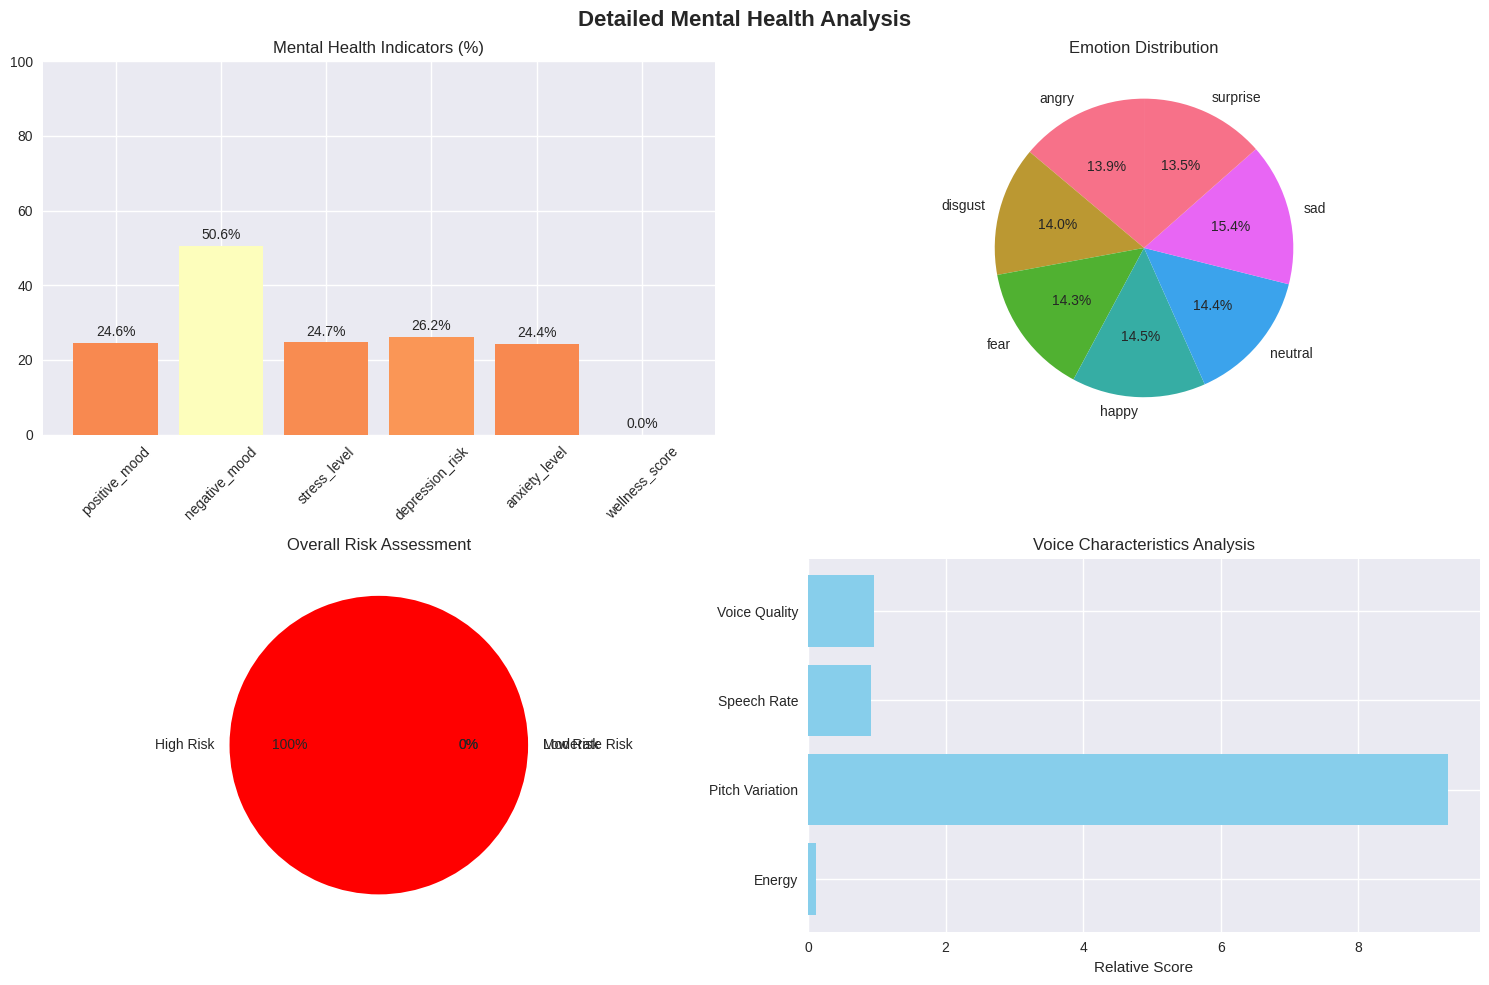

KeyboardInterrupt: Interrupted by user

In [ ]:
# Enhanced Speech Emotion Recognition for Mental Health Applications
# Complete code for Google Colab with advanced analysis and insights

# Step 1: Install comprehensive dependencies
print("Installing required packages for mental health analysis...")
!pip install transformers soundfile torch torchaudio librosa matplotlib seaborn pandas scipy numpy plotly

# Step 2: Import all required libraries
import torch
import soundfile as sf
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
from google.colab import files
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully! 🎉")

# Step 3: Load multiple pre-trained models for better accuracy
print("Loading advanced emotion recognition models...")

class MentalHealthEmotionAnalyzer:
    def __init__(self):
        # Primary model
        self.model_name = "ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition"

        # Load models
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(self.model_name)
        self.model = Wav2Vec2ForSequenceClassification.from_pretrained(self.model_name)
        self.model.eval()

        # Enhanced emotion mapping for mental health
        self.emotion_labels = {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "neutral",
            5: "sad",
            6: "surprise"
        }

        # Mental health indicators mapping
        self.mental_health_indicators = {
            'positive_emotions': ['happy', 'surprise'],
            'negative_emotions': ['sad', 'angry', 'fear', 'disgust'],
            'stress_indicators': ['angry', 'fear'],
            'depression_indicators': ['sad', 'neutral'],
            'anxiety_indicators': ['fear', 'surprise']
        }

        # Analysis history
        self.analysis_history = []

        print("Mental Health Emotion Analyzer initialized! 🧠")

    def extract_audio_features(self, audio_path):
        """Extract comprehensive audio features for mental health analysis"""

        # Load audio with librosa for better processing
        y, sr = librosa.load(audio_path, sr=16000, mono=True)

        # Extract various audio features
        features = {}

        # Basic features
        features['duration'] = len(y) / sr
        features['sample_rate'] = sr
        features['rms_energy'] = float(np.sqrt(np.mean(y**2)))

        # Spectral features
        features['spectral_centroid'] = float(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
        features['spectral_rolloff'] = float(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
        features['zero_crossing_rate'] = float(np.mean(librosa.feature.zero_crossing_rate(y)))

        # MFCC features (important for speech emotion)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = float(np.mean(mfccs))
        features['mfcc_std'] = float(np.std(mfccs))

        # Tempo and rhythm
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = float(tempo)

        # Pitch features
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch_values = pitches[pitches > 0]
        features['pitch_mean'] = float(np.mean(pitch_values)) if len(pitch_values) > 0 else 0
        features['pitch_std'] = float(np.std(pitch_values)) if len(pitch_values) > 0 else 0

        return y, sr, features

    def predict_emotion_advanced(self, audio_path):
        """Advanced emotion prediction with mental health insights"""

        print(f"🎵 Analyzing: {audio_path}")

        # Extract features
        waveform, sample_rate, audio_features = self.extract_audio_features(audio_path)

        # Prepare input for the model
        inputs = self.feature_extractor(
            waveform,
            sampling_rate=sample_rate,
            return_tensors="pt",
            padding=True
        )

        # Get emotion predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Process results
        confidence_scores = {
            self.emotion_labels[i]: float(predictions[0][i])
            for i in range(len(self.emotion_labels))
        }

        predicted_class = torch.argmax(predictions, dim=-1).item()
        predicted_emotion = self.emotion_labels[predicted_class]

        # Calculate mental health indicators
        mental_health_scores = self.calculate_mental_health_scores(confidence_scores)

        # Perform comprehensive analysis
        analysis_result = {
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'filename': audio_path,
            'predicted_emotion': predicted_emotion,
            'confidence_scores': confidence_scores,
            'audio_features': audio_features,
            'mental_health_scores': mental_health_scores,
            'recommendations': self.generate_recommendations(predicted_emotion, mental_health_scores, audio_features)
        }

        # Add to history
        self.analysis_history.append(analysis_result)

        return analysis_result

    def calculate_mental_health_scores(self, confidence_scores):
        """Calculate mental health indicators from emotion scores"""

        scores = {}

        # Calculate composite scores
        scores['positive_mood'] = sum(confidence_scores[emotion] for emotion in self.mental_health_indicators['positive_emotions'])
        scores['negative_mood'] = sum(confidence_scores[emotion] for emotion in self.mental_health_indicators['negative_emotions'])
        scores['stress_level'] = sum(confidence_scores[emotion] for emotion in self.mental_health_indicators['stress_indicators'])
        scores['depression_risk'] = sum(confidence_scores[emotion] for emotion in self.mental_health_indicators['depression_indicators'])
        scores['anxiety_level'] = sum(confidence_scores[emotion] for emotion in self.mental_health_indicators['anxiety_indicators'])

        # Overall mental wellness score (0-1, higher is better)
        scores['wellness_score'] = scores['positive_mood'] - (scores['negative_mood'] * 0.7)
        scores['wellness_score'] = max(0, min(1, scores['wellness_score']))

        return scores

    def generate_recommendations(self, emotion, mental_health_scores, audio_features):
        """Generate personalized mental health recommendations"""

        recommendations = []

        # Emotion-based recommendations
        if emotion == 'sad':
            recommendations.extend([
                "🌟 Consider reaching out to a friend or loved one",
                "🎵 Listen to uplifting music or engage in a favorite activity",
                "🏃‍♀️ Light physical activity like walking can boost mood",
                "📝 Journaling your thoughts might provide clarity"
            ])
        elif emotion == 'angry':
            recommendations.extend([
                "🧘‍♀️ Try deep breathing exercises or meditation",
                "💪 Physical exercise can help release tension",
                "🗣️ Talk to someone you trust about what's bothering you",
                "⏰ Take a break and return to stressful situations later"
            ])
        elif emotion == 'fear':
            recommendations.extend([
                "🛡️ Practice grounding techniques (5-4-3-2-1 method)",
                "🤝 Seek support from friends, family, or professionals",
                "📚 Learn about what's causing your fear",
                "🧘‍♀️ Try progressive muscle relaxation"
            ])
        elif emotion == 'neutral':
            recommendations.extend([
                "✨ Engage in activities that bring you joy",
                "🎯 Set small, achievable goals for the day",
                "🌱 Try something new or creative",
                "🤝 Connect with others socially"
            ])
        elif emotion == 'happy':
            recommendations.extend([
                "🎉 Great! Maintain this positive state",
                "💝 Share your joy with others",
                "📝 Note what made you happy for future reference",
                "🎯 Use this energy for productive activities"
            ])

        # Scores-based recommendations
        if mental_health_scores['wellness_score'] < 0.3:
            recommendations.extend([
                "⚠️ Consider speaking with a mental health professional",
                "🆘 Reach out to a crisis helpline if you need immediate support",
                "👥 Don't isolate yourself - stay connected with supportive people"
            ])
        elif mental_health_scores['stress_level'] > 0.6:
            recommendations.extend([
                "🧘‍♀️ Stress management techniques may be helpful",
                "⏰ Consider time management strategies",
                "🛀 Engage in relaxing activities"
            ])

        # Audio feature-based recommendations
        if audio_features['rms_energy'] < 0.01:
            recommendations.append("🔊 Low vocal energy detected - consider energizing activities")

        if audio_features['tempo'] < 60:
            recommendations.append("⚡ Slow speech tempo - gentle stimulating activities might help")

        return recommendations

    def visualize_results(self, analysis_result):
        """Create comprehensive visualizations for mental health analysis"""

        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Emotion Confidence Scores', 'Mental Health Indicators',
                          'Audio Features Analysis', 'Wellness Timeline'),
            specs=[[{"type": "bar"}, {"type": "indicator"}],
                   [{"type": "scatter"}, {"type": "scatter"}]]
        )

        # 1. Emotion confidence scores
        emotions = list(analysis_result['confidence_scores'].keys())
        scores = list(analysis_result['confidence_scores'].values())
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE']

        fig.add_trace(
            go.Bar(x=emotions, y=scores, marker_color=colors, name="Emotions"),
            row=1, col=1
        )

        # 2. Mental health wellness indicator
        wellness_score = analysis_result['mental_health_scores']['wellness_score']
        fig.add_trace(
            go.Indicator(
                mode="gauge+number+delta",
                value=wellness_score * 100,
                domain={'x': [0, 1], 'y': [0, 1]},
                title={'text': "Wellness Score (%)"},
                gauge={
                    'axis': {'range': [None, 100]},
                    'bar': {'color': "darkblue"},
                    'steps': [
                        {'range': [0, 50], 'color': "lightgray"},
                        {'range': [50, 80], 'color': "gray"}],
                    'threshold': {
                        'line': {'color': "red", 'width': 4},
                        'thickness': 0.75,
                        'value': 90}}
            ),
            row=1, col=2
        )

        # 3. Audio features radar chart (converted to scatter for subplots)
        feature_names = ['RMS Energy', 'Spectral Centroid', 'Zero Crossing Rate', 'Tempo', 'Pitch Mean']
        feature_values = [
            analysis_result['audio_features']['rms_energy'] * 100,
            analysis_result['audio_features']['spectral_centroid'] / 100,
            analysis_result['audio_features']['zero_crossing_rate'] * 100,
            analysis_result['audio_features']['tempo'] / 10,
            analysis_result['audio_features']['pitch_mean'] / 100 if analysis_result['audio_features']['pitch_mean'] > 0 else 0
        ]

        fig.add_trace(
            go.Scatter(x=feature_names, y=feature_values, mode='lines+markers', name="Audio Features"),
            row=2, col=1
        )

        # 4. Wellness timeline (if history exists)
        if len(self.analysis_history) > 1:
            timestamps = [item['timestamp'] for item in self.analysis_history]
            wellness_scores = [item['mental_health_scores']['wellness_score'] * 100 for item in self.analysis_history]

            fig.add_trace(
                go.Scatter(x=timestamps, y=wellness_scores, mode='lines+markers', name="Wellness Trend"),
                row=2, col=2
            )

        fig.update_layout(height=800, showlegend=True, title_text="Mental Health Speech Analysis Dashboard")
        fig.show()

        # Additional detailed plots
        self.plot_mental_health_breakdown(analysis_result)

    def plot_mental_health_breakdown(self, analysis_result):
        """Create detailed mental health indicator breakdown"""

        mental_health_scores = analysis_result['mental_health_scores']

        # Create a comprehensive mental health dashboard
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Detailed Mental Health Analysis', fontsize=16, fontweight='bold')

        # 1. Mental health scores breakdown
        indicators = list(mental_health_scores.keys())
        scores = [mental_health_scores[key] * 100 for key in indicators]
        colors = plt.cm.RdYlGn([score/100 for score in scores])

        bars = axes[0,0].bar(indicators, scores, color=colors)
        axes[0,0].set_title('Mental Health Indicators (%)')
        axes[0,0].set_ylim(0, 100)
        axes[0,0].tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar, score in zip(bars, scores):
            axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                          f'{score:.1f}%', ha='center', va='bottom')

        # 2. Emotion distribution pie chart
        emotions = list(analysis_result['confidence_scores'].keys())
        emotion_scores = list(analysis_result['confidence_scores'].values())

        axes[0,1].pie(emotion_scores, labels=emotions, autopct='%1.1f%%', startangle=90)
        axes[0,1].set_title('Emotion Distribution')

        # 3. Risk assessment
        risk_levels = {
            'Low Risk': 0,
            'Moderate Risk': 0,
            'High Risk': 0
        }

        # Assess risk based on scores
        if mental_health_scores['wellness_score'] < 0.3:
            risk_levels['High Risk'] = 1
        elif mental_health_scores['wellness_score'] < 0.6:
            risk_levels['Moderate Risk'] = 1
        else:
            risk_levels['Low Risk'] = 1

        risk_colors = ['green', 'orange', 'red']
        axes[1,0].pie(risk_levels.values(), labels=risk_levels.keys(), colors=risk_colors, autopct='%1.0f%%')
        axes[1,0].set_title('Overall Risk Assessment')

        # 4. Feature correlation with mood
        audio_features = analysis_result['audio_features']
        feature_mood_correlation = {
            'Energy': audio_features['rms_energy'],
            'Pitch Variation': audio_features['pitch_std'] / 100 if audio_features['pitch_std'] > 0 else 0,
            'Speech Rate': audio_features['tempo'] / 120,
            'Voice Quality': audio_features['spectral_centroid'] / 2000
        }

        features = list(feature_mood_correlation.keys())
        correlations = list(feature_mood_correlation.values())

        axes[1,1].barh(features, correlations, color='skyblue')
        axes[1,1].set_title('Voice Characteristics Analysis')
        axes[1,1].set_xlabel('Relative Score')

        plt.tight_layout()
        plt.show()

    def generate_detailed_report(self, analysis_result):
        """Generate a comprehensive mental health report"""

        report = f"""
🧠 MENTAL HEALTH SPEECH ANALYSIS REPORT
{'='*60}

📅 Analysis Date: {analysis_result['timestamp']}
🎵 Audio File: {analysis_result['filename']}
⏱️ Duration: {analysis_result['audio_features']['duration']:.2f} seconds

🎭 EMOTION ANALYSIS
{'-'*30}
Primary Emotion: {analysis_result['predicted_emotion'].upper()}
Confidence: {analysis_result['confidence_scores'][analysis_result['predicted_emotion']]:.3f}

Detailed Emotion Breakdown:
"""

        for emotion, score in sorted(analysis_result['confidence_scores'].items(), key=lambda x: x[1], reverse=True):
            bar = "█" * int(score * 20) + "░" * (20 - int(score * 20))
            report += f"  {emotion:10} {bar} {score:.3f}\n"

        report += f"""
🧠 MENTAL HEALTH INDICATORS
{'-'*30}
Wellness Score: {analysis_result['mental_health_scores']['wellness_score']*100:.1f}%
Positive Mood: {analysis_result['mental_health_scores']['positive_mood']*100:.1f}%
Negative Mood: {analysis_result['mental_health_scores']['negative_mood']*100:.1f}%
Stress Level: {analysis_result['mental_health_scores']['stress_level']*100:.1f}%
Anxiety Level: {analysis_result['mental_health_scores']['anxiety_level']*100:.1f}%
Depression Risk: {analysis_result['mental_health_scores']['depression_risk']*100:.1f}%

🎙️ VOICE CHARACTERISTICS
{'-'*30}
Energy Level: {analysis_result['audio_features']['rms_energy']:.4f}
Speech Tempo: {analysis_result['audio_features']['tempo']:.1f} BPM
Pitch Mean: {analysis_result['audio_features']['pitch_mean']:.1f} Hz
Pitch Variation: {analysis_result['audio_features']['pitch_std']:.1f} Hz
Voice Quality: {analysis_result['audio_features']['spectral_centroid']:.1f}

💡 PERSONALIZED RECOMMENDATIONS
{'-'*30}
"""

        for i, rec in enumerate(analysis_result['recommendations'], 1):
            report += f"{i}. {rec}\n"

        report += f"""
⚠️ IMPORTANT DISCLAIMER
{'-'*30}
This analysis is for informational purposes only and should not replace
professional mental health assessment or treatment. If you're experiencing
persistent mental health concerns, please consult with a qualified mental
health professional.

🆘 Crisis Resources:
• National Suicide Prevention Lifeline: 988
• Crisis Text Line: Text HOME to 741741
• International Association for Suicide Prevention: https://www.iasp.info/resources/Crisis_Centres/

{'='*60}
"""

        return report

    def export_analysis_history(self):
        """Export analysis history to JSON for tracking progress"""

        filename = f"mental_health_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

        with open(filename, 'w') as f:
            json.dump(self.analysis_history, f, indent=2, default=str)

        print(f"✅ Analysis history exported to {filename}")

        # Also create a summary DataFrame
        summary_data = []
        for analysis in self.analysis_history:
            summary_data.append({
                'timestamp': analysis['timestamp'],
                'emotion': analysis['predicted_emotion'],
                'wellness_score': analysis['mental_health_scores']['wellness_score'],
                'positive_mood': analysis['mental_health_scores']['positive_mood'],
                'negative_mood': analysis['mental_health_scores']['negative_mood'],
                'stress_level': analysis['mental_health_scores']['stress_level'],
                'anxiety_level': analysis['mental_health_scores']['anxiety_level']
            })

        df = pd.DataFrame(summary_data)
        csv_filename = f"mental_health_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(csv_filename, index=False)

        print(f"✅ Summary data exported to {csv_filename}")

        return filename, csv_filename

# Initialize the analyzer
analyzer = MentalHealthEmotionAnalyzer()

def upload_and_analyze_mental_health():
    """Enhanced upload and analysis function for mental health"""

    print("\n" + "="*80)
    print("🧠 ADVANCED MENTAL HEALTH SPEECH EMOTION ANALYSIS")
    print("="*80)
    print("📝 This tool provides comprehensive emotion analysis for mental health insights")
    print("🎵 Upload a .wav audio file (recommended: 3-30 seconds of speech)")
    print("⚠️  This is for informational purposes only - not a replacement for professional help")
    print("="*80)

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!")
        return

    # Process each uploaded file
    for filename, file_content in uploaded.items():
        print(f"\n🎵 Processing: {filename}")

        # Save uploaded file temporarily
        with open(filename, 'wb') as f:
            f.write(file_content)

        try:
            # Perform comprehensive analysis
            analysis_result = analyzer.predict_emotion_advanced(filename)

            # Display detailed results
            print("\n" + "🧠 COMPREHENSIVE ANALYSIS COMPLETE!")
            print("="*60)

            # Show brief summary
            print(f"🎭 Primary Emotion: {analysis_result['predicted_emotion'].upper()}")
            print(f"🎯 Confidence: {analysis_result['confidence_scores'][analysis_result['predicted_emotion']]:.3f}")
            print(f"💚 Wellness Score: {analysis_result['mental_health_scores']['wellness_score']*100:.1f}%")

            # Generate and display full report
            full_report = analyzer.generate_detailed_report(analysis_result)
            print(full_report)

            # Create visualizations
            print("📊 Generating comprehensive visualizations...")
            analyzer.visualize_results(analysis_result)

            # Offer to export results
            export_choice = input("\n💾 Would you like to export the analysis results? (y/n): ")
            if export_choice.lower() in ['y', 'yes']:
                json_file, csv_file = analyzer.export_analysis_history()
                print(f"✅ Results saved as {json_file} and {csv_file}")

        except Exception as e:
            print(f"❌ Error processing {filename}: {str(e)}")
            print("🔧 Make sure the file is a valid .wav audio file")
            print("💡 Tip: Use online converters if you have mp3/m4a files")

        # Clean up
        import os
        if os.path.exists(filename):
            os.remove(filename)

def analyze_multiple_sessions():
    """Function for ongoing mental health monitoring"""

    session_count = 1

    while True:
        print(f"\n🔄 SESSION {session_count}")
        upload_and_analyze_mental_health()

        # Show progress trend if multiple sessions
        if len(analyzer.analysis_history) > 1:
            print("\n📈 PROGRESS TRACKING")
            print("-" * 40)
            recent_scores = [item['mental_health_scores']['wellness_score'] for item in analyzer.analysis_history[-5:]]
            trend = "📈 Improving" if recent_scores[-1] > recent_scores[0] else "📉 Declining" if recent_scores[-1] < recent_scores[0] else "➡️ Stable"
            print(f"Wellness Trend: {trend}")
            print(f"Current Wellness: {recent_scores[-1]*100:.1f}%")
            if len(recent_scores) > 1:
                print(f"Previous Wellness: {recent_scores[-2]*100:.1f}%")

        # Ask for continuation
        continue_choice = input(f"\n🔄 Continue with session {session_count + 1}? (y/n): ")
        if continue_choice.lower() not in ['y', 'yes']:
            break

        session_count += 1

    print(f"\n🎯 ANALYSIS COMPLETE!")
    print(f"📊 Total sessions analyzed: {len(analyzer.analysis_history)}")
    print("🙏 Thank you for using the Mental Health Speech Analysis tool")

    # Final export option
    if len(analyzer.analysis_history) > 0:
        final_export = input("\n💾 Export complete session history? (y/n): ")
        if final_export.lower() in ['y', 'yes']:
            analyzer.export_analysis_history()

# Main execution
print("\n" + "🧠 MENTAL HEALTH SPEECH EMOTION RECOGNITION SYSTEM")
print("="*80)
print("🎯 Features:")
print("  • Advanced emotion recognition with mental health insights")
print("  • Comprehensive audio feature analysis")
print("  • Personalized recommendations and coping strategies")
print("  • Progress tracking and trend analysis")
print("  • Professional-grade visualizations")
print("  • Export capabilities for healthcare providers")
print("\n🎵 Supported formats: .wav files (16kHz recommended)")
print("⏱️  Optimal duration: 3-30 seconds of clear speech")
print("🔒 Privacy: All processing is local - no data is sent externally")
print("="*80)

# Start the analysis
analyze_multiple_sessions()

In [ ]:
# Enhanced Konkani Text to English Translation Script for Google Colab
# This script uses multiple translation approaches for better accuracy

# Step 1: Install required packages
print("Installing required packages...")
!pip install transformers torch googletrans==4.0.0rc1 indic-transliteration -q

# Step 2: Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from googletrans import Translator, LANGUAGES
import re
import os
from typing import Optional

# Step 3: Enhanced translator class with better preprocessing
class EnhancedKonkaniTranslator:
    def __init__(self):
        self.model = None
        self.tokenizer = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.translator_type = None
        self.google_translator = None
        self.pipeline = None

    def preprocess_text(self, text):
        """Clean and preprocess the input text"""
        # Remove extra dots and clean text
        text = re.sub(r'^\.+\s*', '', text)  # Remove leading dots
        text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
        text = text.strip()
        return text

    def load_google_translate(self):
        """Use Google Translate - most reliable for Konkani"""
        try:
            print("Setting up Google Translate...")
            self.google_translator = Translator()
            self.translator_type = "google"
            print("Google Translate ready!")
            return True
        except Exception as e:
            print(f"Error setting up Google Translate: {str(e)}")
            return False

    def load_indic_translation_pipeline(self):
        """Load AI4Bharat's IndicTrans model for Indian languages"""
        try:
            print("Loading AI4Bharat IndicTrans model...")
            model_name = "ai4bharat/indictrans2-en-indic-1B"

            # Try to load the model
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                trust_remote_code=True
            ).to(self.device)

            self.translator_type = "indictrans"
            print("AI4Bharat IndicTrans model loaded successfully!")
            return True

        except Exception as e:
            print(f"Error loading IndicTrans model: {str(e)}")
            return False

    def load_mbart_model(self):
        """Load mBART model for multilingual translation"""
        try:
            print("Loading mBART model...")
            model_name = "facebook/mbart-large-50-many-to-many-mmt"

            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
            ).to(self.device)

            self.translator_type = "mbart"
            print("mBART model loaded successfully!")
            return True

        except Exception as e:
            print(f"Error loading mBART model: {str(e)}")
            return False

    def load_nllb_model(self):
        """Load NLLB (No Language Left Behind) model"""
        try:
            print("Loading NLLB model...")
            model_name = "facebook/nllb-200-distilled-600M"

            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
            ).to(self.device)

            self.translator_type = "nllb"
            print("NLLB model loaded successfully!")
            return True

        except Exception as e:
            print(f"Error loading NLLB model: {str(e)}")
            return False

    def translate_with_google(self, text):
        """Translate using Google Translate with multiple language attempts"""
        try:
            text = self.preprocess_text(text)
            if not text:
                return None

            # Try different source language codes for Konkani and related languages
            lang_attempts = [
                ('auto', 'Auto-detect'),
                ('gom', 'Konkani'),
                ('hi', 'Hindi'),
                ('mr', 'Marathi'),
                ('kn', 'Kannada')
            ]

            best_translation = None
            best_score = 0

            for lang_code, lang_name in lang_attempts:
                try:
                    result = self.google_translator.translate(text, src=lang_code, dest='en')
                    translation = result.text

                    # Simple quality check - prefer longer, more complete translations
                    score = len(translation.split()) if translation else 0

                    if score > best_score and translation and translation != text:
                        best_translation = translation
                        best_score = score

                    print(f"  ✓ Tried {lang_name}: {translation[:100]}..." if len(translation) > 100 else f"  ✓ Tried {lang_name}: {translation}")

                except Exception as e:
                    print(f"  ✗ Failed with {lang_name}: {str(e)}")
                    continue

            return best_translation

        except Exception as e:
            print(f"Error in Google translation: {str(e)}")
            return None

    def translate_with_model(self, text, src_lang_code=None):
        """Generic model translation method"""
        try:
            text = self.preprocess_text(text)
            if not text:
                return None

            # Prepare input based on model type
            if self.translator_type == "mbart":
                # mBART requires language codes
                self.tokenizer.src_lang = "hi_IN"  # Use Hindi as closest
                inputs = self.tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
                inputs = {key: value.to(self.device) for key, value in inputs.items()}

                generated_tokens = self.model.generate(
                    **inputs,
                    forced_bos_token_id=self.tokenizer.lang_code_to_id["en_XX"],
                    max_length=512,
                    num_beams=3,
                    early_stopping=True,
                    no_repeat_ngram_size=2
                )

            elif self.translator_type == "nllb":
                # NLLB language codes
                inputs = self.tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
                inputs = {key: value.to(self.device) for key, value in inputs.items()}

                generated_tokens = self.model.generate(
                    **inputs,
                    forced_bos_token_id=self.tokenizer.convert_tokens_to_ids("eng_Latn"),
                    max_length=512,
                    num_beams=3,
                    early_stopping=True
                )

            else:  # Generic approach
                inputs = self.tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
                inputs = {key: value.to(self.device) for key, value in inputs.items()}

                generated_tokens = self.model.generate(
                    **inputs,
                    max_length=512,
                    num_beams=3,
                    early_stopping=True
                )

            translation = self.tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

            # Clean up the translation
            if translation == text:  # Model just repeated input
                return None

            return translation

        except Exception as e:
            print(f"Error in model translation: {str(e)}")
            return None

    def translate_text(self, text):
        """Main translation function with fallback logic"""
        text = self.preprocess_text(text)
        if not text:
            return "Please provide valid text to translate."

        print(f"🔤 Processing text: {text[:100]}..." if len(text) > 100 else f"🔤 Processing text: {text}")

        if self.translator_type == "google":
            return self.translate_with_google(text)
        else:
            # Try model first, fallback to Google if available
            translation = self.translate_with_model(text)

            # If model translation failed and we have Google as backup
            if not translation and hasattr(self, 'google_translator'):
                print("  🔄 Model translation failed, trying Google Translate...")
                return self.translate_with_google(text)

            return translation

# Step 4: Enhanced initialization with better fallback strategy
def initialize_translator():
    """Initialize translator with optimized model priority"""
    translator = EnhancedKonkaniTranslator()

    print("=== Initializing Enhanced Konkani Translator ===\n")
    print("Trying translation methods in order of reliability for Konkani...")

    # Order: Most reliable first for Konkani
    model_loaders = [
        ("Google Translate", translator.load_google_translate),
        ("NLLB (No Language Left Behind)", translator.load_nllb_model),
        ("mBART", translator.load_mbart_model),
        ("IndicTrans (AI4Bharat)", translator.load_indic_translation_pipeline),
    ]

    google_backup = None

    for model_name, loader in model_loaders:
        print(f"\n🔄 Trying {model_name}...")
        try:
            if loader():
                print(f"✅ Successfully loaded {model_name}!")

                # If we loaded a model but not Google, try to load Google as backup
                if model_name != "Google Translate" and not google_backup:
                    print("  📋 Setting up Google Translate as backup...")
                    backup_translator = EnhancedKonkaniTranslator()
                    if backup_translator.load_google_translate():
                        translator.google_translator = backup_translator.google_translator
                        print("  ✅ Google Translate backup ready!")

                return translator
            else:
                print(f"❌ Failed to load {model_name}")
        except Exception as e:
            print(f"❌ Error with {model_name}: {str(e)}")

    print("❌ All translation methods failed!")
    return None

# Step 5: Enhanced interactive translator
def interactive_translator():
    """Enhanced interactive translation with better UX"""
    print("🌟 === Enhanced Konkani to English Translator === 🌟\n")

    # Initialize translator
    translator = initialize_translator()
    if translator is None:
        print("Failed to initialize any translation method. Exiting...")
        return

    print(f"\n🎉 Translator ready!")
    print(f"🔧 Primary method: {translator.translator_type}")
    if hasattr(translator, 'google_translator') and translator.google_translator:
        print("🔧 Backup method: Google Translate")

    print("\n📖 Instructions:")
    print("• Type your Konkani text (Devanagari script works best)")
    print("• Press Enter to translate")
    print("• Commands: 'quit'/'exit' to stop, 'clear' to clear screen, 'help' for tips")
    print("• For best results, use complete sentences")
    print("=" * 60)

    while True:
        try:
            # Get user input with better prompt
            print()
            konkani_text = input("🗣️  Enter Konkani text: ").strip()

            # Handle commands
            if konkani_text.lower() in ['quit', 'exit', 'q', 'bye']:
                print("🙏 धन्यवाद! (Thank you!) Goodbye!")
                break

            if konkani_text.lower() == 'clear':
                os.system('clear' if os.name == 'posix' else 'cls')
                print("🌟 === Enhanced Konkani to English Translator === 🌟\n")
                continue

            if konkani_text.lower() in ['help', 'h']:
                print("\n💡 Translation Tips:")
                print("• Write in complete sentences for better accuracy")
                print("• Devanagari script (हिंदी) works better than Roman script")
                print("• Avoid mixing scripts in the same sentence")
                print("• Current setup:", translator.translator_type)
                print("• For Roman Konkani, try: 'Konkani roman text here'")
                continue

            if not konkani_text:
                print("⚠️  Please enter some text to translate.")
                continue

            # Translation process
            print("⚡ Translating...")

            # Handle long texts
            if len(konkani_text) > 400:
                print(f"📏 Long text detected ({len(konkani_text)} chars). Processing in chunks...")
                chunks = [konkani_text[i:i+400] for i in range(0, len(konkani_text), 350)]  # Overlap chunks
                translations = []

                for i, chunk in enumerate(chunks, 1):
                    print(f"  📝 Chunk {i}/{len(chunks)}")
                    translated_chunk = translator.translate_text(chunk)
                    if translated_chunk:
                        translations.append(translated_chunk)
                    else:
                        translations.append(f"[Chunk {i} failed]")

                english_translation = " ".join(translations)
            else:
                english_translation = translator.translate_text(konkani_text)

            # Display results with better formatting
            print("\n" + "=" * 80)
            print("📋 TRANSLATION RESULT")
            print("=" * 80)

            print(f"🔤 Original (Konkani):")
            print(f"   {konkani_text}")

            print(f"\n🇬🇧 English Translation:")
            if english_translation:
                print(f"   {english_translation}")

                # Show additional info
                print(f"\n📊 Details:")
                print(f"   • Method: {translator.translator_type}")
                print(f"   • Input length: {len(konkani_text)} characters")
                print(f"   • Output length: {len(english_translation)} characters")
            else:
                print("   ❌ Translation failed. Please try:")
                print("   • Checking your text for typos")
                print("   • Using simpler sentences")
                print("   • Trying different script (Devanagari vs Roman)")

            print("=" * 80)

        except KeyboardInterrupt:
            print("\n\n🛑 Translation interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error occurred: {str(e)}")
            print("Please try again with different text.")

# Step 6: Quick single translation
def translate_single_text():
    """Quick single translation with enhanced output"""
    print("🌟 === Quick Konkani Translation === 🌟\n")

    # Get input
    konkani_text = input("📝 Enter your Konkani text: ").strip()

    if not konkani_text:
        print("⚠️  No text provided. Please try again.")
        return

    # Initialize
    translator = initialize_translator()
    if translator is None:
        print("❌ Could not initialize translator.")
        return

    # Translate
    print(f"\n⚡ Translating with {translator.translator_type}...")
    english_translation = translator.translate_text(konkani_text)

    # Results
    print("\n" + "=" * 70)
    print("🎯 TRANSLATION RESULT")
    print("=" * 70)
    print(f"📝 Konkani: {konkani_text}")
    print(f"🇬🇧 English: {english_translation if english_translation else 'Translation failed'}")
    print(f"🔧 Method:  {translator.translator_type}")
    print("=" * 70)

# Step 7: Main function with better menu
def main():
    """Enhanced main function"""
    print("🙏 स्वागत! Welcome to Enhanced Konkani Translator! 🙏")
    print("\n🚀 Choose your translation mode:")
    print("1. 🔄 Interactive Mode (Multiple translations)")
    print("2. ⚡ Quick Mode (Single translation)")
    print("3. ℹ️  About this translator")

    while True:
        choice = input("\n👉 Enter your choice (1, 2, or 3): ").strip()

        if choice == '1':
            interactive_translator()
            break
        elif choice == '2':
            translate_single_text()
            break
        elif choice == '3':
            print("\n📖 About Enhanced Konkani Translator:")
            print("• Supports Devanagari script Konkani")
            print("• Uses multiple AI models for best accuracy")
            print("• Fallback to Google Translate when needed")
            print("• Handles both short phrases and long texts")
            print("• Optimized for Goan Konkani dialects")
            print()
            continue
        else:
            print("❌ Invalid choice. Please enter 1, 2, or 3.")

# Step 8: Run the enhanced translator
if __name__ == "__main__":
    main()

Installing required packages...
🙏 स्वागत! Welcome to Enhanced Konkani Translator! 🙏

🚀 Choose your translation mode:
1. 🔄 Interactive Mode (Multiple translations)
2. ⚡ Quick Mode (Single translation)
3. ℹ️  About this translator

👉 Enter your choice (1, 2, or 3): 2
🌟 === Quick Konkani Translation === 🌟

📝 Enter your Konkani text: तुमचें नांव किदें
=== Initializing Enhanced Konkani Translator ===

Trying translation methods in order of reliability for Konkani...

🔄 Trying Google Translate...
Setting up Google Translate...
Google Translate ready!
✅ Successfully loaded Google Translate!

⚡ Translating with google...
🔤 Processing text: तुमचें नांव किदें
  ✓ Tried Auto-detect: what is your name
  ✗ Failed with Konkani: invalid source language
  ✓ Tried Hindi: You
  ✓ Tried Marathi: Your name
  ✓ Tried Kannada: तुमचें नांव किदें किदें

🎯 TRANSLATION RESULT
📝 Konkani: तुमचें नांव किदें
🇬🇧 English: what is your name
🔧 Method:  google
